## In this notebook, we will
1. Import reduction potential data for over 5000 molecules
2. Perform data cleaning operations (correlated feature elimination and p-value hypothesis testing) using customised classes and methods.
3. Split data into 80-20 training and testing tests and save as .csv files for training ML models in the following notebooks

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 

from Functions import ChemClean
from Functions import Descriptors

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [4]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,CCC1Oc2cc3nsnc3c(CC(C)C)c2OC1CC,1.37
1,CC(C)c1ccc2nsnc2c1,1.63
2,COCCOC1N(C)c2cc3nsnc3cc2N1C(C)C,1.15
3,Cc1c2c(c(C)c3nsnc13)N(C(C)C)CN2C,1.15
4,CCCN1CN(C(C)C)c2cc3nsnc3c(/[NH+]=C(\C)[O-])c21,1.15


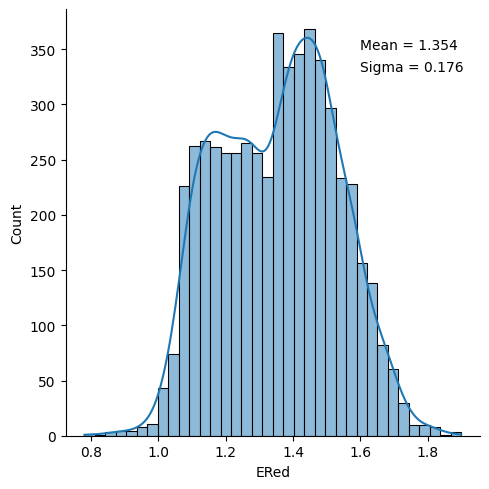

In [5]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [6]:
%%time
p=Descriptors.desc(data['SMILES'])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5442, 208)
CPU times: user 46 s, sys: 4.65 s, total: 50.7 s
Wall time: 50.6 s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.305972,0.122646,6.305972,0.122646,0.848122,306.431,284.255,306.140199,114,0,...,0,0,0,0,0,0,0,0,0,0
1,4.192315,0.565833,4.192315,0.565833,0.670692,178.260,168.180,178.056469,62,0,...,0,0,0,0,0,0,0,0,0,0
2,6.003857,-0.120065,6.003857,0.120065,0.790105,308.407,288.247,308.130697,114,0,...,0,0,0,0,0,0,0,0,1,0
3,4.460762,0.496153,4.460762,0.496153,0.790721,262.382,244.238,262.125218,96,0,...,0,0,0,0,0,0,0,0,0,0
4,11.670496,-0.081347,11.670496,0.081347,0.659521,319.434,298.266,319.146681,118,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [7]:
p=ChemClean.clean(df_rdkit)

In [8]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)

# VERIFY HOW FEATURES ARE REMOVED AFTER CHECKING FOR CORRELATION


print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5442, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,6.305972,0.122646,306.431,1.142857,9.981899,-2.388255,2.126286,-1.36,23.241334,11.499024,...,0.000000,8.702458,0.000000,0,1,0,0,0,2,0
1,4.192315,0.565833,178.260,1.166667,10.031887,-1.852454,2.601030,-0.96,11.033401,0.000000,...,0.000000,4.363023,0.000000,0,0,0,0,0,1,0
2,6.003857,-0.120065,308.407,1.190476,10.183884,-2.468380,1.970088,-1.44,11.033401,0.000000,...,4.410278,5.481833,3.728398,0,1,0,0,0,2,1
3,4.460762,0.496153,262.382,1.055556,10.038578,-2.334533,2.377252,-1.36,11.033401,0.000000,...,4.756852,9.742074,2.152067,0,1,0,0,2,2,0
4,11.670496,-0.081347,319.434,1.454545,10.140055,-2.694406,2.283493,-1.89,17.101832,5.516701,...,7.640238,9.847211,0.000000,1,1,0,0,0,2,0


In [9]:
target=data['ERed']
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,6.305972,0.122646,306.431,1.142857,9.981899,-2.388255,2.126286,-1.36,23.241334,11.499024,...,0.000000,8.702458,0.000000,0,1,0,0,0,2,0
1,4.192315,0.565833,178.260,1.166667,10.031887,-1.852454,2.601030,-0.96,11.033401,0.000000,...,0.000000,4.363023,0.000000,0,0,0,0,0,1,0
2,6.003857,-0.120065,308.407,1.190476,10.183884,-2.468380,1.970088,-1.44,11.033401,0.000000,...,4.410278,5.481833,3.728398,0,1,0,0,0,2,1
3,4.460762,0.496153,262.382,1.055556,10.038578,-2.334533,2.377252,-1.36,11.033401,0.000000,...,4.756852,9.742074,2.152067,0,1,0,0,2,2,0
4,11.670496,-0.081347,319.434,1.454545,10.140055,-2.694406,2.283493,-1.89,17.101832,5.516701,...,7.640238,9.847211,0.000000,1,1,0,0,0,2,0


## Feature elimination using p-value test; using Linear Regression

### p-values calculated using ordinary least squares fit

In [10]:
mod = sm.OLS(target,features)
fii = mod.fit()
fii.summary2().tables[1].head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
MaxEStateIndex,0.032146,0.002572,12.498263,2.343020e-35,0.027104,0.037188
MinEStateIndex,0.024024,0.008888,2.702920,6.894821e-03,0.006600,0.041449
MolWt,-0.006181,0.000579,-10.669231,2.587961e-26,-0.007317,-0.005045
FpDensityMorgan1,0.040480,0.011253,3.597217,3.245165e-04,0.018419,0.062540
BCUT2D_MWLOW,0.019360,0.011387,1.700172,8.915612e-02,-0.002963,0.041683


### Recursive elimination of all features whose p-value < alpha (=0.02)

In [26]:
alpha=0.02
for a in range(len(features.columns)):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
columns=features.columns
columns

Final model has (5442, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

## Split into 80-20 training and testing sets and save to csv files

In [59]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [51]:
features_train.index=range(features_train.shape[0])
features_train.to_csv('Data/features_train.csv')
features_test.index=range(features_test.shape[0])
features_test.to_csv('Data/features_test.csv')
target_train.index=range(target_train.shape[0])
target_train.to_csv('Data/target_train.csv')
target_test.index=range(target_test.shape[0])
target_test.to_csv('Data/target_test.csv')

In [61]:
print('Training set contains',target_train.shape[0],'entries')
print('Testing set contains',target_test.shape[0],'entries')

Training set contains 4353 entries
Testing set contains 1089 entries


## Scale the features and save to csv files

In [53]:
scaler=StandardScaler()

In [54]:
features_train=scaler.fit_transform(features_train)
features_test=scaler.transform(features_test)

In [56]:
features_train=pd.DataFrame(features_train,columns=columns)
features_train.to_csv('Data/features_train_scaled.csv',index=False)
features_test=pd.DataFrame(features_test,columns=columns)
features_test.to_csv('Data/features_test_scaled.csv',index=False)

### Visualise distribution of reduction potentials in the training and testing datasets

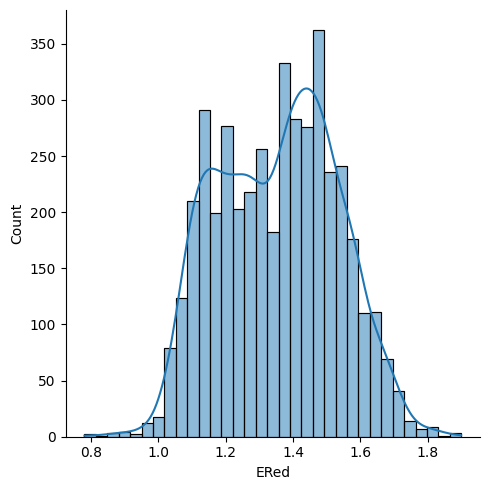

In [57]:
Ered_train=pd.read_csv('Data/target_train.csv')
ax=sns.displot(Ered_train,x='ERed',kde=True)
plt.show()

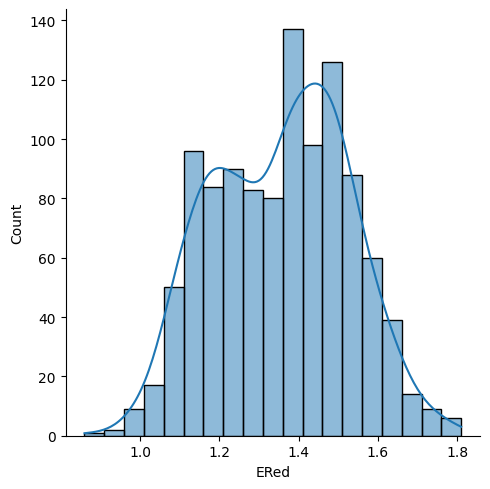

In [58]:
Ered_test=pd.read_csv('Data/target_test.csv')
ax=sns.displot(Ered_test,x='ERed',kde=True)
plt.show()

In the next notebook, <font color = blue>2.MolRedPot_Regression.ipynb
</font>, we will develop cross-validated simple linear and ensemble regression models to predict the reduction potential of these molecules.